c:\Users\stloc\OneDrive\Documents\School\Summer_2025\SENG474\SENG474_flight_pricing_model\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\stloc\AppData\Local\Temp\ipykernel_13492\2540242601.py:17: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


Dataset shape: (1581278, 26)
First 5 records:
   MktCoupons  OriginCityMarketID  DestCityMarketID  OriginAirportID  \
0           2                 178               152              170   
1           2                 178               152              170   
2           2                 178               152              170   
3           2                 178               152              170   
4           2                 178               152              170   

   DestAirportID  Carrier  NonStopMiles  RoundTrip  ODPairID    Pax  ...  \
0            255        6        1807.0        1.0      4035  136.0  ...   
1            194       20        1798.0        1.0      4035  136.0  ...   
2            260        6        1784.0        0.0      4035  136.0  ...   
3            255        6        1807.0        1.0      4035  136.0  ...   
4            194       20        1798.0        1.0      4035  136.0  ...   

   Circuity  Slot  Non_Stop  MktMilesFlown  OriginCityMarketID_f

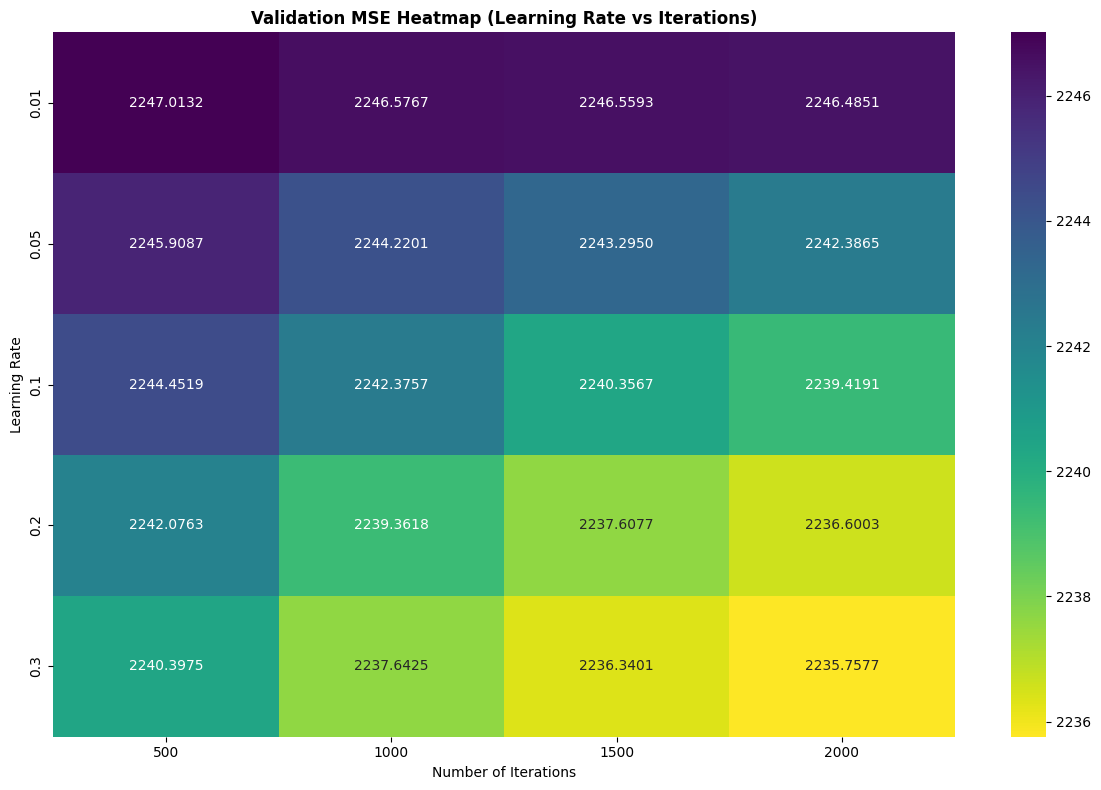


GENERATING LEARNING CURVES
Training size: 94876 samples (10.0%) - Train MSE: 2281.7165, Val MSE: 2236.4748
Training size: 189753 samples (20.0%) - Train MSE: 2275.9848, Val MSE: 2235.9373
Training size: 284629 samples (30.0%) - Train MSE: 2264.5694, Val MSE: 2235.8348
Training size: 379506 samples (40.0%) - Train MSE: 2260.5806, Val MSE: 2235.9113
Training size: 474383 samples (50.0%) - Train MSE: 2260.3805, Val MSE: 2235.7668
Training size: 569259 samples (60.0%) - Train MSE: 2263.5956, Val MSE: 2235.7827
Training size: 664136 samples (70.0%) - Train MSE: 2254.8086, Val MSE: 2235.7472
Training size: 759012 samples (80.0%) - Train MSE: 2256.3658, Val MSE: 2235.7562
Training size: 853889 samples (90.0%) - Train MSE: 2254.5533, Val MSE: 2235.7521
Training size: 948766 samples (100.0%) - Train MSE: 2261.0779, Val MSE: 2235.7654


In [1]:
import kagglehub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from kagglehub import KaggleDatasetAdapter

from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import time

# Download and load data (keeping your original data loading code)
path = kagglehub.dataset_download("orvile/airline-market-fare-prediction-data")
file_path = "Airline_Market_Fare_Prediction_Data/MarketFarePredictionData.csv"

df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "orvile/airline-market-fare-prediction-data",
    file_path,
)

print("Dataset shape:", df.shape)
print("First 5 records:")
print(df.head())

# Your original functions (keeping them unchanged)
def linear_regression_normal_equation(X, y):
    X_b = np.c_[np.ones((X.shape[0], 1)), X]
    theta = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y
    return theta

def predict(X, theta):
    X_b = np.c_[np.ones((X.shape[0], 1)), X]
    return X_b.dot(theta)

def linear_regression_gradient_descent(X, y, learning_rate, num_iterations, verbose=False):
    m = X.shape[0]
    X_b = np.c_[np.ones((m, 1)), X]
    theta = np.random.randn(X_b.shape[1], 1)
    cost_history = []
    
    for i in range(num_iterations):
        gradients = (2/m) * X_b.T.dot(X_b.dot(theta) - y)
        theta -= learning_rate * gradients
        
        predictions = X_b.dot(theta)
        cost = np.mean((predictions - y) ** 2)
        cost_history.append(cost)
        
        if verbose and (i % 100 == 0 or i == num_iterations - 1):
            print(f"Iteration {i:4d}: MSE = {cost:.4f}")
    
    return theta, cost_history

# 60/20/20 Data Split
X_full = df[['NonStopMiles', 'MktMilesFlown', 'Market_HHI', 'Market_share', 'MktCoupons']].values
y_full = df["Average_Fare"].values.reshape(-1, 1)

# First split: 60% train, 40% temp
X_train, X_temp, y_train, y_temp = train_test_split(X_full, y_full, test_size=0.4, random_state=42)

# Second split: 20% validation, 20% test from the 40% temp
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"\nData Split Summary:")
print(f"Training samples:   {X_train.shape[0]} ({X_train.shape[0]/len(X_full)*100:.1f}%)")
print(f"Validation samples: {X_val.shape[0]} ({X_val.shape[0]/len(X_full)*100:.1f}%)")
print(f"Test samples:       {X_test.shape[0]} ({X_test.shape[0]/len(X_full)*100:.1f}%)")

# Feature scaling
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

# Hyperparameter Tuning
print("\n" + "="*50)
print("HYPERPARAMETER TUNING")
print("="*50)

learning_rates = [0.01, 0.05, 0.1, 0.2, 0.3]
iterations_list = [500, 1000, 1500, 2000]

best_val_mse = float('inf')
best_params = {}
results = []

for lr in learning_rates:
    for iterations in iterations_list:
        print(f"\nTesting: lr={lr}, iterations={iterations}")
        
        # Train model
        theta_gd, cost_history = linear_regression_gradient_descent(
            X_train_scaled, y_train, lr, iterations, verbose=False
        )
        
        # Validate
        y_val_pred = predict(X_val_scaled, theta_gd)
        val_mse = mean_squared_error(y_val, y_val_pred)
        
        # Train error for comparison
        y_train_pred = predict(X_train_scaled, theta_gd)
        train_mse = mean_squared_error(y_train, y_train_pred)
        
        results.append({
            'learning_rate': lr,
            'iterations': iterations,
            'train_mse': train_mse,
            'val_mse': val_mse
        })
        
        print(f"  Train MSE: {train_mse:.4f}, Val MSE: {val_mse:.4f}")
        
        if val_mse < best_val_mse:
            best_val_mse = val_mse
            best_params = {'learning_rate': lr, 'iterations': iterations}
            best_theta = theta_gd

print(f"\nBest Parameters: {best_params}")
print(f"Best Validation MSE: {best_val_mse:.4f}")

# Create hyperparameter results visualization
results_df = pd.DataFrame(results)
pivot_table = results_df.pivot_table(values='val_mse', index='learning_rate', columns='iterations')

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, fmt='.4f', cmap='viridis_r')
plt.title('Validation MSE Heatmap (Learning Rate vs Iterations)', fontweight='bold')
plt.xlabel('Number of Iterations')
plt.ylabel('Learning Rate')
plt.tight_layout()
plt.show()

# Learning Curves
print("\n" + "="*50)
print("GENERATING LEARNING CURVES")
print("="*50)

def generate_learning_curves(X_train, y_train, X_val, y_val, learning_rate, iterations):
    train_sizes = np.linspace(0.1, 1.0, 10)
    train_errors = []
    val_errors = []
    
    for size in train_sizes:
        # Use a fraction of training data
        n_samples = int(size * len(X_train))
        X_subset = X_train[:n_samples]
        y_subset = y_train[:n_samples]
        
        # Train model on subset
        theta, _ = linear_regression_gradient_descent(
            X_subset, y_subset, learning_rate, iterations, verbose=False
        )
        
        # Calculate errors
        train_pred = predict(X_subset, theta)
        val_pred = predict(X_val, theta)
        
        train_mse = mean_squared_error(y_subset, train_pred)
        val_mse = mean_squared_error(y_val, val_pred)
        
        train_errors.append(train_mse)
        val_errors.append(val_mse)
        
        print(f"Training size: {n_samples:4d} samples ({size*100:4.1f}%) - Train MSE: {train_mse:.4f}, Val MSE: {val_mse:.4f}")
    
    return train_sizes * len(X_train), train_errors, val_errors

# Generate learning curves with best parameters
train_sizes, train_errors, val_errors = generate_learning_curves(
    X_train_scaled, y_train, X_val_scaled, y_val,
    best_params['learning_rate'], best_params['iterations']
)

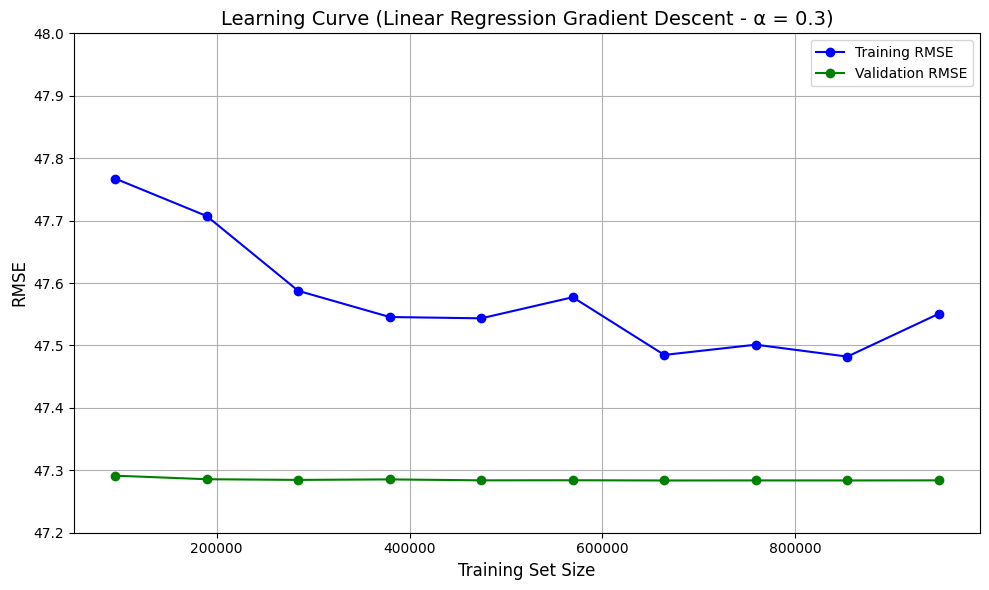

In [2]:
# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.sqrt(train_errors), 'o-', label="Training RMSE", color='blue')
plt.plot(train_sizes, np.sqrt(val_errors), 'o-', label="Validation RMSE", color='green')
plt.xlabel("Training Set Size", fontsize=12)
plt.ylabel("RMSE", fontsize=12)
plt.title(f'Learning Curve (Linear Regression Gradient Descent - α = {best_params["learning_rate"]})', fontsize=14)
plt.legend()
plt.grid(True)
# plt.xlim(0, 800000)
plt.ylim(47.2, 48)
plt.tight_layout()
plt.show()



In [3]:


# Final Model Evaluation
print("\n" + "="*50)
print("FINAL MODEL EVALUATION")
print("="*50)

# Train final model with best parameters on full training set
final_theta, final_cost_history = linear_regression_gradient_descent(
    X_train_scaled, y_train, 
    best_params['learning_rate'], 
    best_params['iterations'], 
    verbose=True
)

# Evaluate on all sets
y_train_final_pred = predict(X_train_scaled, final_theta)
y_val_final_pred = predict(X_val_scaled, final_theta)
y_test_final_pred = predict(X_test_scaled, final_theta)

train_mse_final = mean_squared_error(y_train, y_train_final_pred)
val_mse_final = mean_squared_error(y_val, y_val_final_pred)
test_mse_final = mean_squared_error(y_test, y_test_final_pred)

train_r2_final = r2_score(y_train, y_train_final_pred)
val_r2_final = r2_score(y_val, y_val_final_pred)
test_r2_final = r2_score(y_test, y_test_final_pred)

print(f"\nFinal Model Performance:")
print(f"Training   MSE: {train_mse_final:.4f}, R²: {train_r2_final:.4f}")
print(f"Validation MSE: {val_mse_final:.4f}, R²: {val_r2_final:.4f}")
print(f"Test       MSE: {test_mse_final:.4f}, R²: {test_r2_final:.4f}")




FINAL MODEL EVALUATION
Iteration    0: MSE = 9889.2935
Iteration  100: MSE = 2271.0743
Iteration  200: MSE = 2269.4826
Iteration  300: MSE = 2268.1338
Iteration  400: MSE = 2266.9907
Iteration  500: MSE = 2266.0221
Iteration  600: MSE = 2265.2012
Iteration  700: MSE = 2264.5056
Iteration  800: MSE = 2263.9161
Iteration  900: MSE = 2263.4166
Iteration 1000: MSE = 2262.9933
Iteration 1100: MSE = 2262.6345
Iteration 1200: MSE = 2262.3305
Iteration 1300: MSE = 2262.0729
Iteration 1400: MSE = 2261.8546
Iteration 1500: MSE = 2261.6696
Iteration 1600: MSE = 2261.5128
Iteration 1700: MSE = 2261.3799
Iteration 1800: MSE = 2261.2673
Iteration 1900: MSE = 2261.1719
Iteration 1999: MSE = 2261.0918

Final Model Performance:
Training   MSE: 2261.0918, R²: 0.5817
Validation MSE: 2235.7787, R²: 0.5798
Test       MSE: 2250.8471, R²: 0.5819


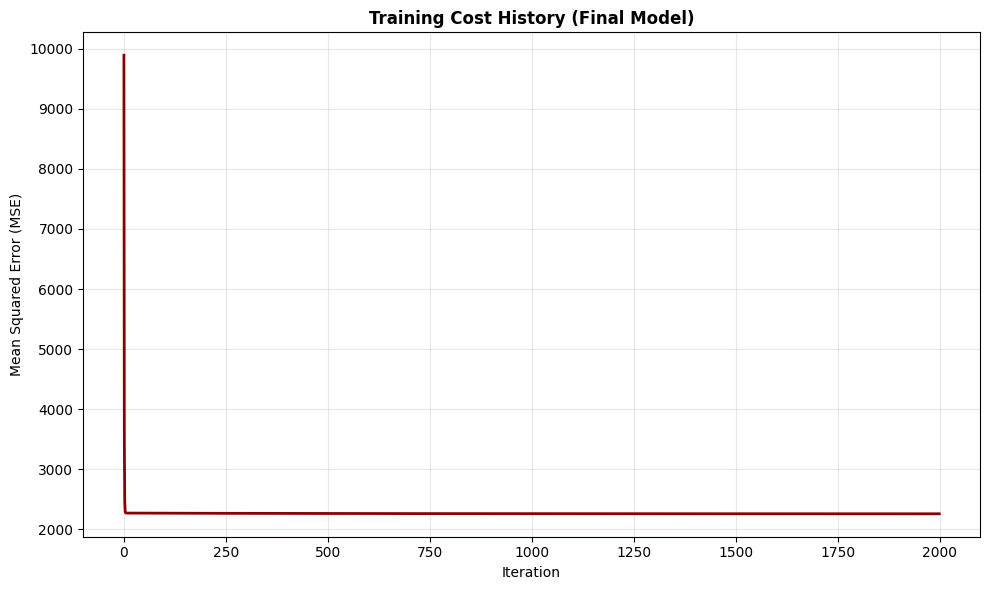

In [4]:

# Plot final cost history
plt.figure(figsize=(10, 6))
plt.plot(range(len(final_cost_history)), final_cost_history, color='darkred', linewidth=2)
plt.title(f"Training Cost History (Final Model)", fontweight='bold')
plt.xlabel("Iteration")
plt.ylabel("Mean Squared Error (MSE)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [5]:
# Compare with Normal Equation (baseline)
print("\n" + "="*50)
print("COMPARISON WITH NORMAL EQUATION")
print("="*50)

theta_normal = linear_regression_normal_equation(X_train, y_train)
y_test_normal_pred = predict(X_test, theta_normal)
test_mse_normal = mean_squared_error(y_test, y_test_normal_pred)
test_r2_normal = r2_score(y_test, y_test_normal_pred)

print(f"Normal Equation Test MSE: {test_mse_normal:.4f}, R²: {test_r2_normal:.4f}")
print(f"Gradient Descent Test MSE: {test_mse_final:.4f}, R²: {test_r2_final:.4f}")
print(f"Difference in MSE: {abs(test_mse_normal - test_mse_final):.6f}")


COMPARISON WITH NORMAL EQUATION
Normal Equation Test MSE: 2250.3875, R²: 0.5819
Gradient Descent Test MSE: 2250.8471, R²: 0.5819
Difference in MSE: 0.459663



PREDICTION vs ACTUAL PLOTS


C:\Users\stloc\AppData\Local\Temp\ipykernel_13492\2649900161.py:46: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
c:\Users\stloc\OneDrive\Documents\School\Summer_2025\SENG474\SENG474_flight_pricing_model\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


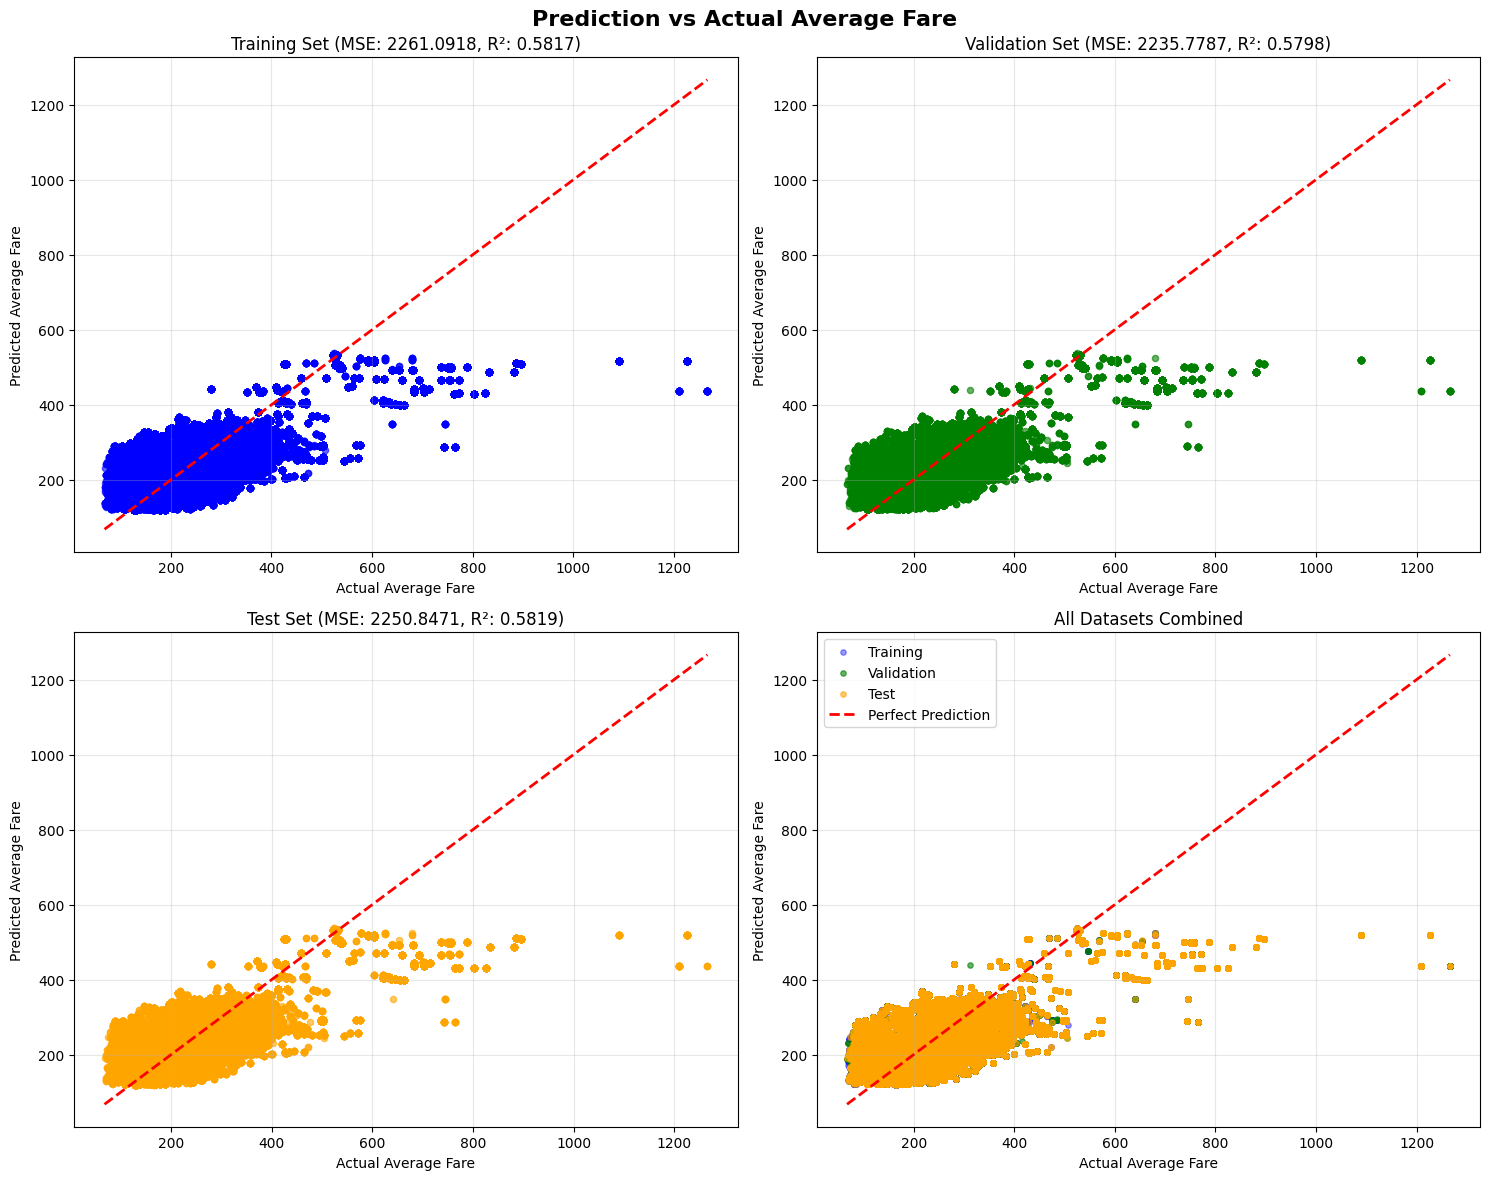

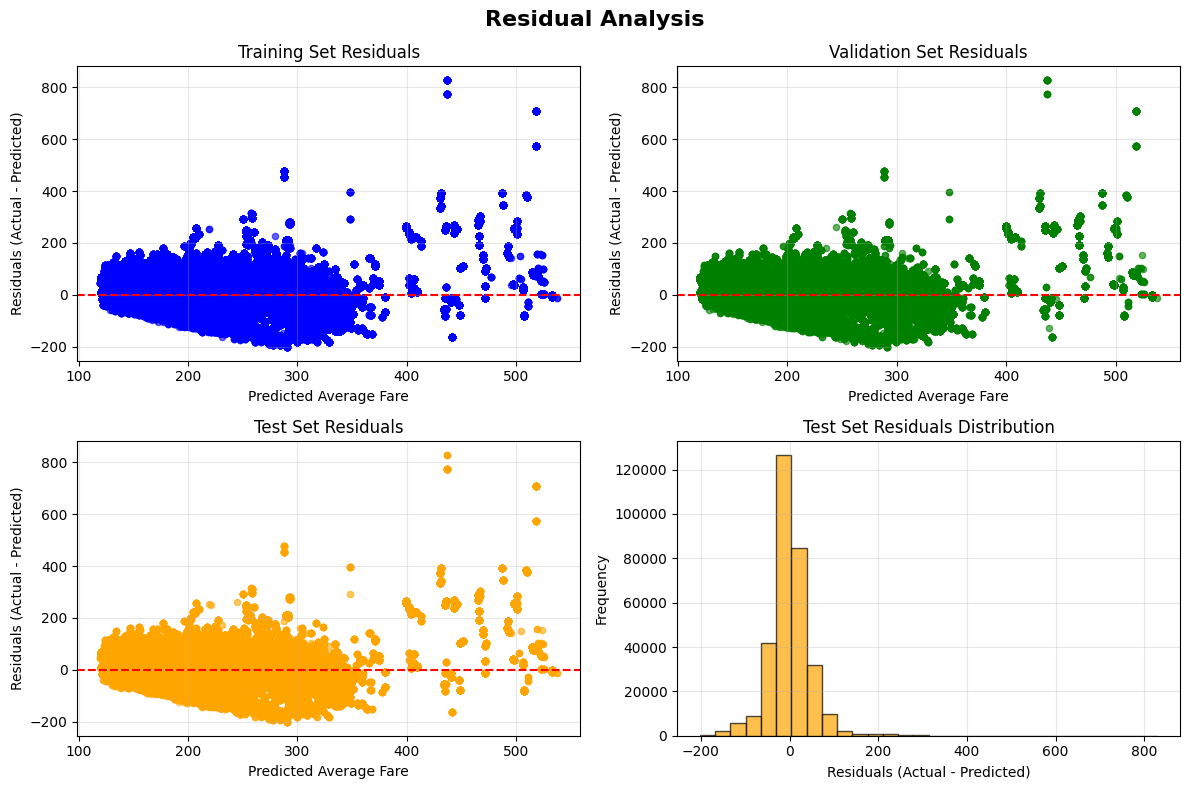

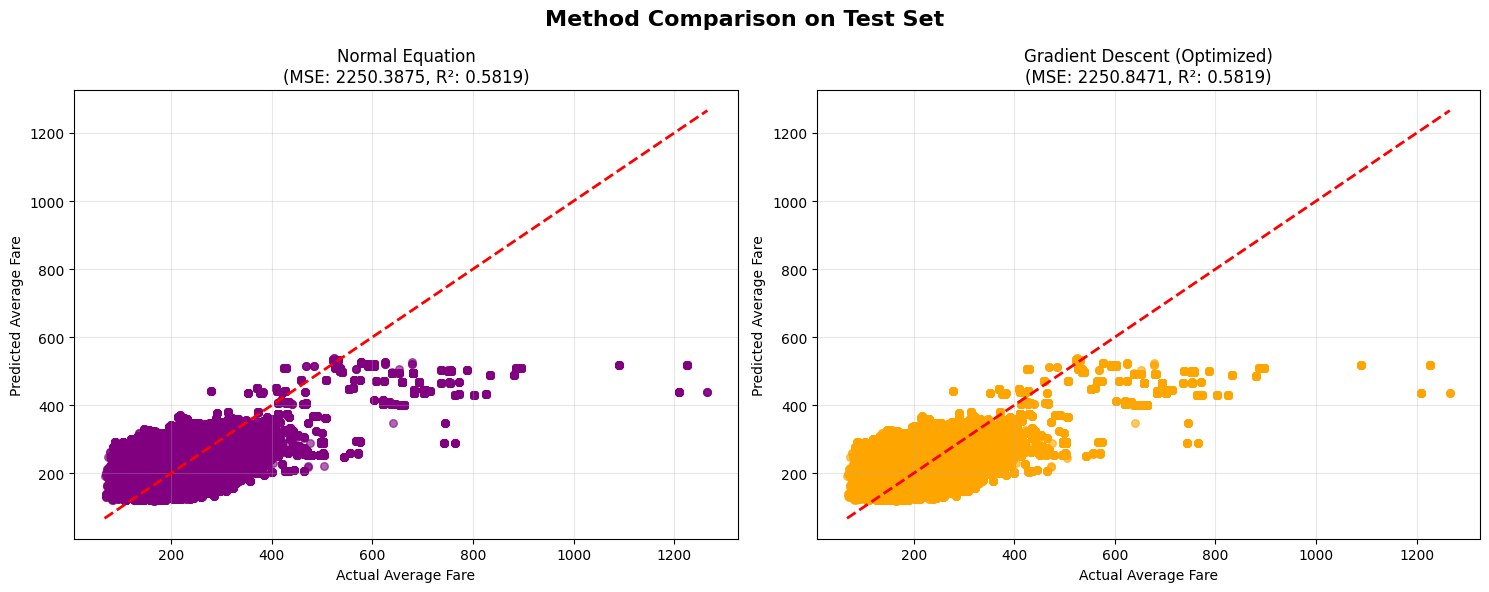

In [6]:

# Prediction vs Actual Plots
print("\n" + "="*50)
print("PREDICTION vs ACTUAL PLOTS")
print("="*50)

# Create subplots for different datasets
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Prediction vs Actual Average Fare', fontsize=16, fontweight='bold')

# Training Set
axes[0, 0].scatter(y_train, y_train_final_pred, alpha=0.6, color='blue', s=20)
axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual Average Fare')
axes[0, 0].set_ylabel('Predicted Average Fare')
axes[0, 0].set_title(f'Training Set (MSE: {train_mse_final:.4f}, R²: {train_r2_final:.4f})')
axes[0, 0].grid(True, alpha=0.3)

# Validation Set
axes[0, 1].scatter(y_val, y_val_final_pred, alpha=0.6, color='green', s=20)
axes[0, 1].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
axes[0, 1].set_xlabel('Actual Average Fare')
axes[0, 1].set_ylabel('Predicted Average Fare')
axes[0, 1].set_title(f'Validation Set (MSE: {val_mse_final:.4f}, R²: {val_r2_final:.4f})')
axes[0, 1].grid(True, alpha=0.3)

# Test Set
axes[1, 0].scatter(y_test, y_test_final_pred, alpha=0.6, color='orange', s=20)
axes[1, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1, 0].set_xlabel('Actual Average Fare')
axes[1, 0].set_ylabel('Predicted Average Fare')
axes[1, 0].set_title(f'Test Set (MSE: {test_mse_final:.4f}, R²: {test_r2_final:.4f})')
axes[1, 0].grid(True, alpha=0.3)

# Combined plot with all datasets
axes[1, 1].scatter(y_train, y_train_final_pred, alpha=0.4, color='blue', s=15, label='Training')
axes[1, 1].scatter(y_val, y_val_final_pred, alpha=0.6, color='green', s=15, label='Validation')
axes[1, 1].scatter(y_test, y_test_final_pred, alpha=0.6, color='orange', s=15, label='Test')
all_actual = np.concatenate([y_train, y_val, y_test])
axes[1, 1].plot([all_actual.min(), all_actual.max()], [all_actual.min(), all_actual.max()], 'r--', lw=2, label='Perfect Prediction')
axes[1, 1].set_xlabel('Actual Average Fare')
axes[1, 1].set_ylabel('Predicted Average Fare')
axes[1, 1].set_title('All Datasets Combined')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# Residual Plot
plt.figure(figsize=(12, 8))

# Calculate residuals
train_residuals = y_train.flatten() - y_train_final_pred.flatten()
val_residuals = y_val.flatten() - y_val_final_pred.flatten()
test_residuals = y_test.flatten() - y_test_final_pred.flatten()

plt.subplot(2, 2, 1)
plt.scatter(y_train_final_pred, train_residuals, alpha=0.6, color='blue', s=20)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Average Fare')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Training Set Residuals')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 2)
plt.scatter(y_val_final_pred, val_residuals, alpha=0.6, color='green', s=20)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Average Fare')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Validation Set Residuals')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 3)
plt.scatter(y_test_final_pred, test_residuals, alpha=0.6, color='orange', s=20)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Average Fare')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Test Set Residuals')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 4)
plt.hist(test_residuals, bins=30, alpha=0.7, color='orange', edgecolor='black')
plt.xlabel('Residuals (Actual - Predicted)')
plt.ylabel('Frequency')
plt.title('Test Set Residuals Distribution')
plt.grid(True, alpha=0.3)

plt.suptitle('Residual Analysis', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Side-by-side comparison plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Normal Equation
ax1.scatter(y_test, y_test_normal_pred, alpha=0.6, color='purple', s=30)
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
ax1.set_xlabel('Actual Average Fare')
ax1.set_ylabel('Predicted Average Fare')
ax1.set_title(f'Normal Equation\n(MSE: {test_mse_normal:.4f}, R²: {test_r2_normal:.4f})')
ax1.grid(True, alpha=0.3)

# Gradient Descent
ax2.scatter(y_test, y_test_final_pred, alpha=0.6, color='orange', s=30)
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
ax2.set_xlabel('Actual Average Fare')
ax2.set_ylabel('Predicted Average Fare')
ax2.set_title(f'Gradient Descent (Optimized)\n(MSE: {test_mse_final:.4f}, R²: {test_r2_final:.4f})')
ax2.grid(True, alpha=0.3)

plt.suptitle('Method Comparison on Test Set', fontsize=16, fontweight='bold')
plt.tight_layout()